In [2]:
import torch 
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision import datasets
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
import sys
sys.path.append('/home/kadenw/Workspace/dog_scanner/dog_scanner')
from dog_scanner import (
    plot_loss_curves,
    train_step,
    test_step,
    train
)

In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

sdogs_path = '/home/kadenw/Workspace/dog_scanner/data/stanford_dogs/images/Images'

IMAGE_SIZE = (128, 128)

aug_transform = transforms.Compose([
    transforms.Resize(size = IMAGE_SIZE),
    transforms.TrivialAugmentWide(), #AutoAugment(policy=AutoAugmentPolicy.IMAGENET) <- loss/acc got stuck
    transforms.ToTensor()
])
orig_transform = transforms.Compose([
    transforms.Resize(size = IMAGE_SIZE),
    transforms.ToTensor()
])

data = datasets.ImageFolder(root = sdogs_path,
                            transform = orig_transform,
                            target_transform = None)
total_size = len(data)
train_size = int(total_size*0.8)
test_size = total_size-train_size
train_data, test_data = random_split(data, [train_size, test_size])

aug_train_data = Subset(datasets.ImageFolder(root=sdogs_path, 
                                       transform=aug_transform),
                                       train_data.indices)
comb = torch.utils.data.ConcatDataset([train_data, aug_train_data])

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = comb, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

NameError: name 'torch' is not defined

In [10]:
#import ResNet? or other pretrained model
class dog_classify(nn.Module):
    def __init__(self, input_shape: int, filters: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=filters, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.Conv2d(in_channels=filters, 
                      out_channels=filters,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.MaxPool2d(2)
        )
        self.residual_connection = nn.Conv2d(in_channels=input_shape, 
                                             out_channels=filters, 
                                             kernel_size=1, 
                                             stride=4,  # Adjust the stride to match the downsampling due to MaxPool
                                             padding=0)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=filters*32*32,
                      out_features=filters*32),
            nn.ReLU(),
            nn.Linear(in_features = filters*32,
                      out_features = output_shape),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x: torch.Tensor):
        residual = self.residual_connection(x)
        #print(residual.shape)
        #print(x.shape)
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = x + residual
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [11]:
# Set number of epochs
epochs = 500

# Recreate an instance of TinyVGG
dog_scanner = dog_classify(input_shape=3, # number of color channels (3 for RGB) 
                  filters=10, 
                  output_shape=len(data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=dog_scanner.parameters(), lr=0.001) #, weight_decay=1e-7)

# Start the timer 
start_time = timer()

# Train model_0 
dog_scanner_results = train(model=dog_scanner, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7897 | train_acc: 0.0118 | test_loss: 4.7903 | test_acc: 0.0000
Epoch: 2 | train_loss: 4.7903 | train_acc: 0.0114 | test_loss: 4.7903 | test_acc: 0.0000
Epoch: 3 | train_loss: 4.7901 | train_acc: 0.0116 | test_loss: 4.7900 | test_acc: 0.0000
Epoch: 4 | train_loss: 4.7896 | train_acc: 0.0121 | test_loss: 4.7890 | test_acc: 0.0000
Epoch: 5 | train_loss: 4.7886 | train_acc: 0.0131 | test_loss: 4.7887 | test_acc: 0.0000
Epoch: 6 | train_loss: 4.7897 | train_acc: 0.0120 | test_loss: 4.7925 | test_acc: 0.0000
Epoch: 7 | train_loss: 4.7926 | train_acc: 0.0091 | test_loss: 4.7924 | test_acc: 0.0000
Epoch: 8 | train_loss: 4.7918 | train_acc: 0.0099 | test_loss: 4.7911 | test_acc: 0.0000
Epoch: 9 | train_loss: 4.7929 | train_acc: 0.0088 | test_loss: 4.7933 | test_acc: 0.0000
Epoch: 10 | train_loss: 4.7927 | train_acc: 0.0090 | test_loss: 4.7920 | test_acc: 0.0000
Epoch: 11 | train_loss: 4.7921 | train_acc: 0.0096 | test_loss: 4.7930 | test_acc: 0.0000
Epoch: 12 | train_l

KeyboardInterrupt: 

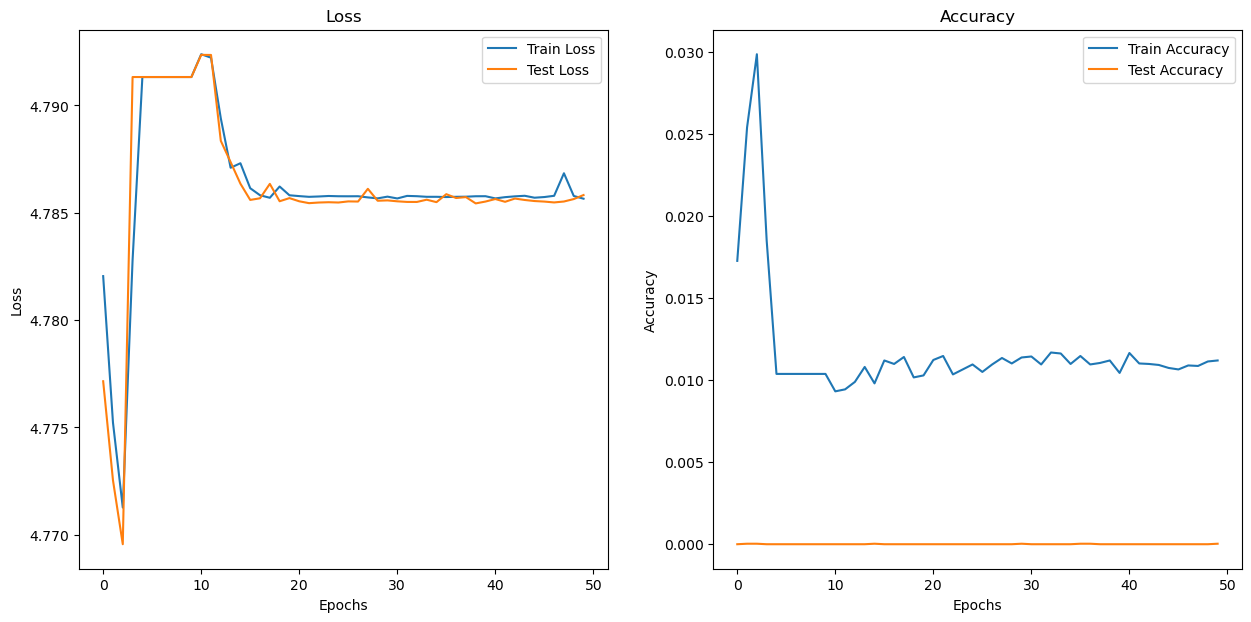

In [93]:
plot_loss_curves(dog_scanner_results)